In [6]:
import xarray as xr
import numpy as np
import cartopy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import dask
from tqdm import tqdm
from scipy.special import gammaln

In [7]:
ds = {}
for m in [1]:
    ds[m] = xr.open_zarr(f'/nethome/sebil001/NEMO_Ensemble/Pspacetime_{m:03d}.zarr/')
    s = np.where(ds[m].time[:,0]==ds[m].time[0,0])[0]
    dspace = ds[m].isel(traj=s).load()
    s = np.where(np.logical_and(ds[m].lon[:,0]==ds[m].lon[0,0], ds[m].lat[:,0]==ds[m].lat[0,0]))[0]
    dtime = ds[m].isel(traj=s).load()
    dzero = ds[m].sel(traj=0).load()
print(dspace)
print(dtime)
print(dzero)


<xarray.Dataset>
Dimensions:     (traj: 81, obs: 365)
Dimensions without coordinates: traj, obs
Data variables:
    lat         (traj, obs) float64 30.0 30.01 30.01 30.02 ... 28.47 28.47 28.47
    lon         (traj, obs) float64 -75.0 -75.04 -75.09 ... -71.06 -71.0 -70.94
    time        (traj, obs) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31...
    trajectory  (traj) float64 0.0 720.0 1.44e+03 ... 5.688e+04 5.76e+04
    z           (traj, obs) float64 1.0 1.006 1.002 0.9934 ... 5.783 5.784 5.795
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.1-108-g4bac223f
<xarray.Dataset>
Dimensions:     (traj: 30, obs: 365)
Dimensions without coordinates: traj, obs
Data variables:
    lat         (traj, obs) float64 30.0 30.01 30.01 30.02 ... nan nan nan nan
    lon         (traj, obs) float64 -75.0 -75.04 -75.09 

In [8]:
dmem = xr.open_zarr(f'/nethome/sebil001/NEMO_Ensemble/Pspacetime_1p_001.zarr/').load()
for m in range(2, 51):
    ds = xr.open_zarr(f'/nethome/sebil001/NEMO_Ensemble/Pspacetime_1p_{m:03d}.zarr/').load()
    dmem = xr.concat([dmem, ds], dim='traj')
    
dmem

<xarray.Dataset>
Dimensions:     (traj: 50, obs: 365)
Dimensions without coordinates: traj, obs
Data variables:
    lat         (traj, obs) float64 30.0 30.01 30.01 30.02 ... 31.85 31.79 31.72
    lon         (traj, obs) float64 -75.0 -75.04 -75.09 ... -69.99 -69.92 -69.86
    time        (traj, obs) datetime64[ns] 2010-01-01T12:00:00 ... 2010-12-31...
    trajectory  (traj) float64 0.0 1.0 2.0 3.0 4.0 ... 45.0 46.0 47.0 48.0 49.0
    z           (traj, obs) float64 1.0 1.006 1.002 0.9934 ... 8.89 8.93 8.911
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.1-108-g4bac223f

In [9]:
domain_limits = [[-85, -40], [10, 45]] # [lon_min, lon_max], [lat_min, lat_max]

# Probability of finding particles along a trajectory

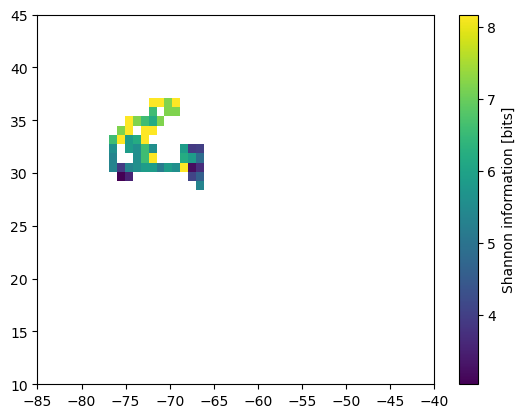

In [10]:
particle = 40
H = np.zeros((50, 40))

nx, ny = 50, 40

for i in range(0, 1):
    
    h, x_, y_ = np.histogram2d(dspace.lon[i, :], dspace.lat[i, :], bins=[nx, ny], range=domain_limits, density=True)
    # h[np.where(h>0)] = 2
    h[np.where(h==0)] = 1
    
    H -= np.log2(h)

H[np.where(H==0)] = np.nan
plt.pcolormesh(x_, y_, H.T)
plt.colorbar(label='Shannon information [bits]')

In [11]:
PDF = np.zeros((nx, ny))

for dt in range(0, len(dspace.obs)):
    pdf, _, _ = np.histogram2d(dspace.lon[:, dt], dspace.lat[:, dt], bins=[nx, ny], range=domain_limits, density=True)
    
    PDF += pdf
    
PDF[np.where(PDF==0)] = np.nan

PDF = PDF / (len(dspace.obs)*len(dspace.traj))

In [12]:
len(dspace.traj)

81

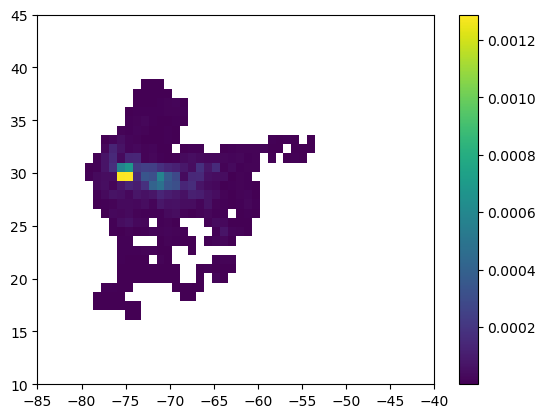

In [13]:
plt.pcolormesh(x_, y_, PDF.T)
plt.colorbar(label='')

# Sensitivity to initial conditions

> What is the minimum distance particles need to be released so their trajectories match between them (fully redundant).

Lyapunov exponents?

Text(0, 0.5, 'Latitude')

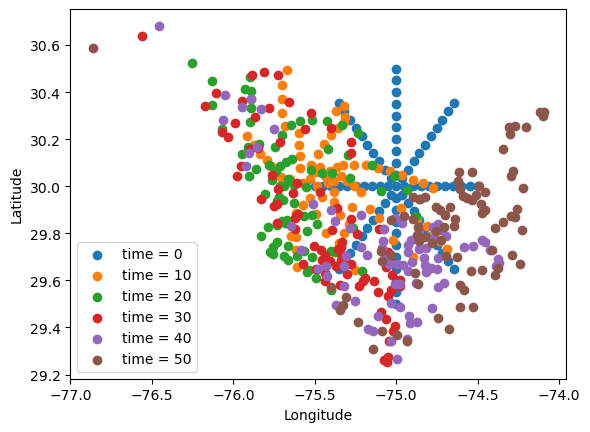

In [14]:
for i in range(0, 51, 10):
    plt.scatter(dspace.lon[:, i], dspace.lat[:, i], label=f'time = {i}')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

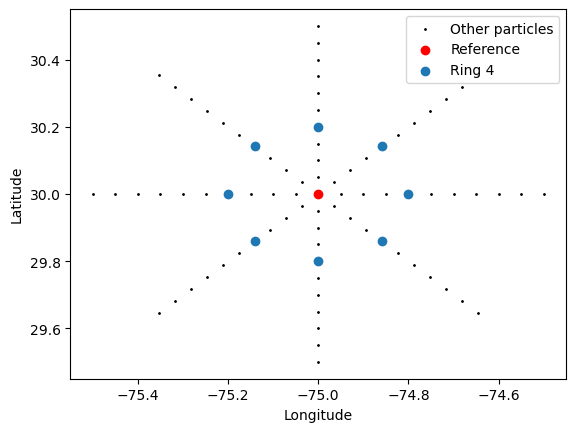

In [15]:
i = 0

plt.scatter(dspace.lon[:, i], dspace.lat[:, i], label='Other particles', s=1, c='k')
plt.scatter(dspace.lon[0, i], dspace.lat[0, i], label=f'Reference', c= 'r')


n = 4
R = range(8*(n-1) + 1, 8*n + 1)

plt.scatter(dspace.lon[R, i], dspace.lat[R, i], label=f'Ring {n}')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [16]:
def haversine_distance_two(point_A, point_B):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    """
    lat1, lon1 = point_A
    lat2, lon2 = point_B
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [17]:
time = range(0, 365)

ring_distances = {}

for n in range(0, 11):
    R = range(8*(n-1) + 1, 8*n + 1)

    ring_distances[n] = haversine_distance_two((dspace.lat[0, time], dspace.lon[0, time]), (dspace.lat[R, time], dspace.lon[R, time])).values


In [18]:
np.mean(ring_distances[1], axis=0).shape

(365,)

Text(0.5, 0, 'Time')

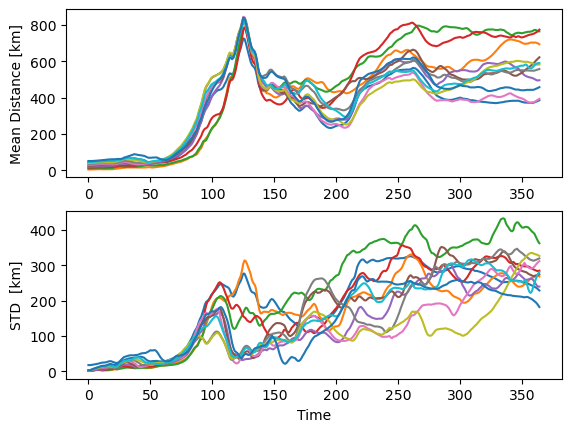

In [19]:
time = range(0, 365)
# plot the mean and std in two subplots
plt.figure()


for r in range(0, 11):
    mean = np.mean(ring_distances[r], axis=0)
    std = np.std(ring_distances[r], axis=0)
    plt.subplot(211)
    plt.plot(time, mean)
    plt.subplot(212)
    plt.plot(time, std)

plt.subplot(211)

plt.ylabel('Mean Distance [km]')
plt.subplot(212)
plt.ylabel('STD  [km]')
plt.xlabel('Time')

# Encoder: Demoting Type

Large data source might have redundancies already in them.

An ensemble has ${x, A_x, P_x}$:
- Random variable $x$
- A set of possible outcomes or and alphabet $A_x = {a_1, a_2, ..., a_i}$
- A set of probabilities $p(x=a_i) = p_i$

In [20]:
dsingle = dspace.astype(np.single)
dhalf = dspace.astype(np.half)
dint = dspace.astype(int)

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: overflow encountered in cast
  return data.astype(dtype, **kwargs)


Text(0, 0.5, 'Latitude')

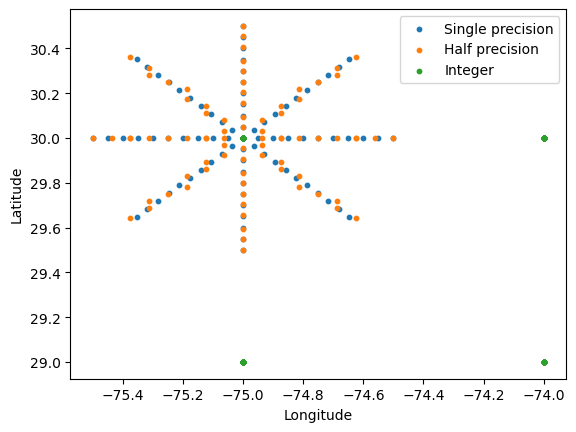

In [21]:
i = 0 #range(0, 365)

plt.scatter(dsingle.lon[:, i], dsingle.lat[:, i], label=f'Single precision', s=10)
plt.scatter(dhalf.lon[:, i], dhalf.lat[:, i], label='Half precision', s=10)
plt.scatter(dint.lon[:, i], dint.lat[:, i], label='Integer', s=10)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

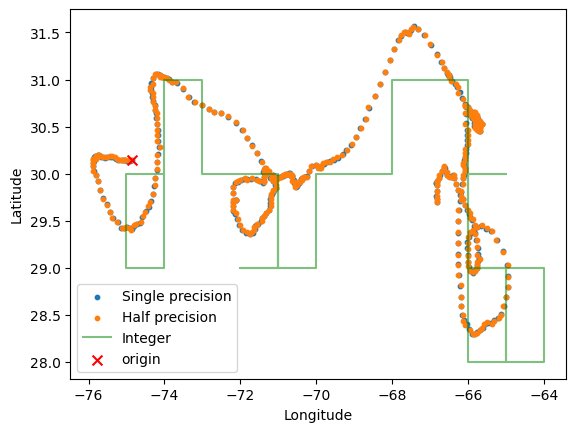

In [22]:
i = range(0, 365)
p = 26
plt.scatter(dsingle.lon[p, i], dsingle.lat[p, i], label=f'Single precision', s=10)
plt.scatter(dhalf.lon[p, i], dhalf.lat[p, i], label='Half precision', s=10)
plt.plot(dint.lon[p, i], dint.lat[p, i], label='Integer', c='g', alpha=0.5)
plt.scatter(dsingle.lon[p, 0], dsingle.lat[p, 0], label=f'origin', s=50, marker='x', c='r')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

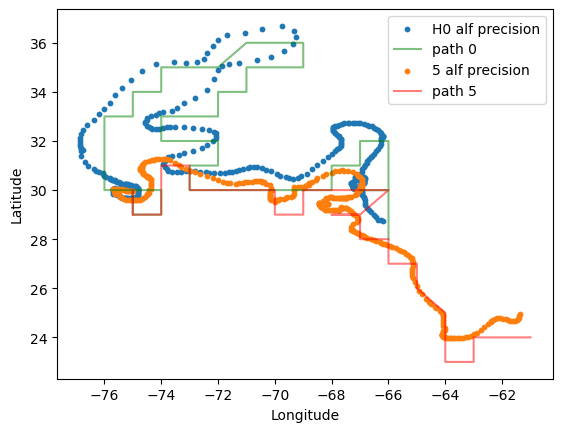

In [23]:
i = range(0, 365)
p = 0


plt.scatter(dhalf.lon[p, i], dhalf.lat[p, i], label=f'H{p} alf precision', s=10)
plt.plot(dint.lon[p, i], dint.lat[p, i], label=f'path {p}', c='g', alpha=0.5)

p = 5
plt.scatter(dhalf.lon[p, i], dhalf.lat[p, i], label=f'{p} alf precision', s=10)
plt.plot(dint.lon[p, i], dint.lat[p, i], label=f'path {p}', c='r', alpha=0.5)
# plt.scatter(dhalf.lon[p, i], dhalf.lat[p, i], label=f'{p} alf precision', s=10)

# plt.scatter(dhalf.lon[p, 0], dhalf.lat[p, 0], label='origin', s=40)
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0.5, 1.0, 'All particles')

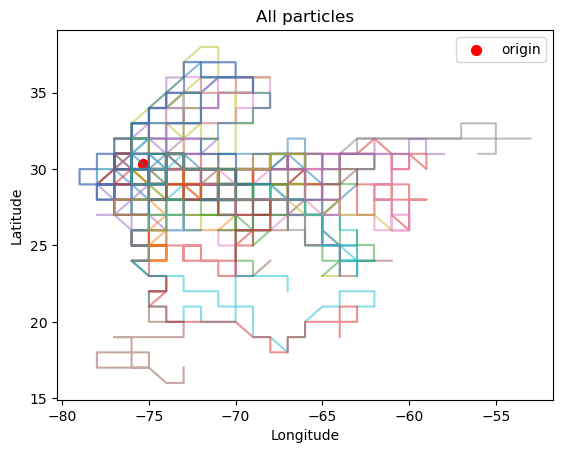

In [24]:
i = range(0, 365)

for p in range(0, 81):
    plt.plot(dint.lon[p, i], dint.lat[p, i], alpha=0.5)

plt.scatter(dsingle.lon[p, 0], dsingle.lat[p, 0], label=f'origin', s=50, marker='o', c='r')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('All particles')

# Decoder: Matching trajectories between pairs of particles (Agreement)

In [25]:
time = range(0, 365)
p = 0

initial_agreement = np.zeros((81, 81))
Agreement = np.zeros((81, 81))

for i in range(0, 81):
    for j in range(0, 81):
    
        if i == j:
            Agreement[i, j] = np.nan
            initial_agreement[i, j] = np.nan
        else:
            matching_traj = (dint.lon[i, time] == dint.lon[j, time]) & (dint.lat[i, time] == dint.lat[j, time])
            # get index of first false or disagreement
            idx = np.where(matching_traj == False)[0][0]
            # count the number of agreements, which is the index of the first disagreement
            initial_agreement[i, j] = idx
            Agreement[i, j] = np.sum(matching_traj)

Text(0.5, 1.0, 'Agreement between particle paths')

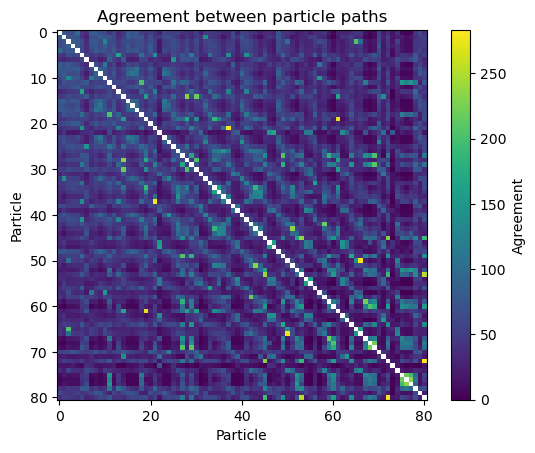

In [26]:
plt.imshow(Agreement)
plt.colorbar(label='Agreement')
plt.xlabel('Particle')
plt.ylabel('Particle')
plt.title('Agreement between particle paths')

Text(0.5, 1.0, 'Agreement between particle INITIAL paths')

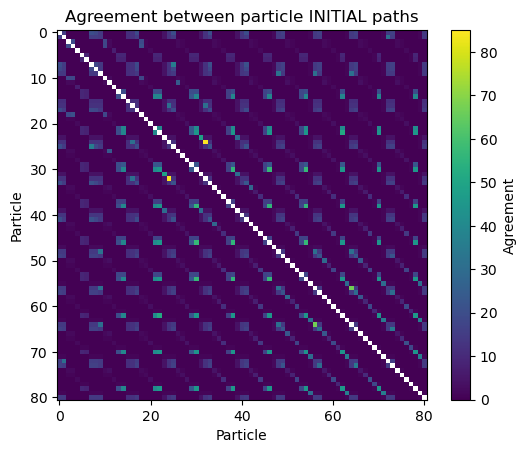

In [27]:
plt.imshow(initial_agreement)
plt.colorbar(label='Agreement')
plt.xlabel('Particle')
plt.ylabel('Particle')
plt.title('Agreement between particle INITIAL paths')

In [28]:
max_agreement = np.where(Agreement == np.nanmax(Agreement))

In [29]:
max_agreement[0]

array([72, 80])

Text(0.5, 1.0, 'Particle pair with highest agreement =283.0')

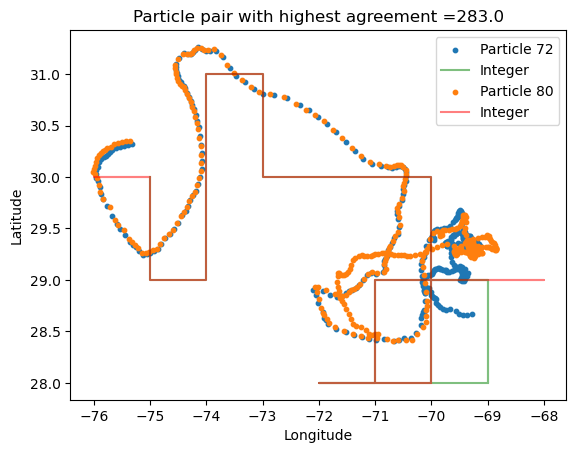

In [30]:
i = range(0, 365)
p = max_agreement[0][0]
# plt.scatter(dsingle.lon[p, i], dsingle.lat[p, i], label=f'Single precision', s=10)

plt.scatter(dspace.lon[p, i], dspace.lat[p, i], label=f"Particle {p}", s=10)
plt.plot(dint.lon[p, i], dint.lat[p, i], label="Integer", c="g", alpha=0.5)
p = max_agreement[0][1]
plt.scatter(dspace.lon[p, i], dspace.lat[p, i], label=f"Particle {p}", s=10)
plt.plot(dint.lon[p, i], dint.lat[p, i], label='Integer', c='r', alpha=0.5)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Particle pair with highest agreement ={np.nanmax(Agreement)}")

Text(0, 0.5, 'Latitude')

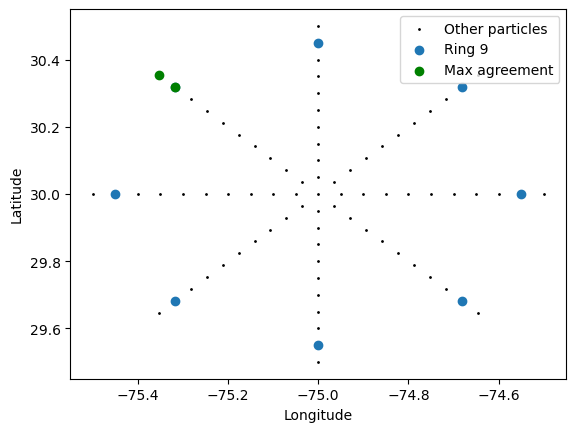

In [36]:
i = 0

plt.scatter(dspace.lon[:, i], dspace.lat[:, i], label='Other particles', s=1, c='k')

n = 9
R = range(8*(n-1) + 1, 8*n + 1)

plt.scatter(dspace.lon[R, i], dspace.lat[R, i], label=f'Ring {n}')
plt.scatter(dspace.lon[max_agreement[0], i], dspace.lat[max_agreement[0], i], label=f'Max agreement', c='g')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [37]:
p_space = np.zeros(365)
p_space_initial = np.zeros(365)

for d in range(0, 365):
    A = np.where(Agreement == d)
    p_space[d] = (
        len(A[0]) / 81**2 / 2
    )  # divide by 2 to avoid double counting and diveded by number of pairs to get the probability

    Ai = np.where(initial_agreement == d)
    p_space_initial[d] = (
        len(Ai[0]) / 81**2 / 2
    )  # divide by 2 to avoid double counting and diveded by number of pairs to get the probability


H_space = p_space * np.log2(1 / p_space)
H_space_initial = p_space_initial * np.log2(1 / p_space_initial)

# drop nans and sum H_space
H_space = H_space[~np.isnan(H_space)]
H_space_initial = H_space_initial[~np.isnan(H_space_initial)]

H_space = np.sum(H_space)
H_space_initial = np.sum(H_space_initial)

print(f"Information content Agreement = {H_space} bits")
print(f"Information content Initial Agreement = {H_space_initial} bits")

Information content Agreement = 3.8187967621300825 bits
Information content Initial Agreement = 1.4599052263818129 bits


/tmp/ipykernel_524237/1845216175.py:16: RuntimeWarning: divide by zero encountered in divide
  H_space = p_space * np.log2(1 / p_space)
/tmp/ipykernel_524237/1845216175.py:17: RuntimeWarning: divide by zero encountered in divide
  H_space_initial = p_space_initial * np.log2(1 / p_space_initial)


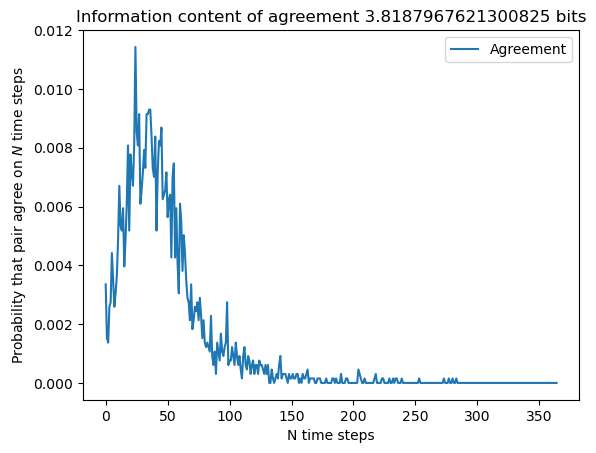

In [38]:
plt.plot(p_space, label="Agreement")
plt.title(f"Information content of agreement {H_space} bits")
plt.xlabel("N time steps")
plt.ylabel("Probability that pair agree on $N$ time steps")
plt.legend()

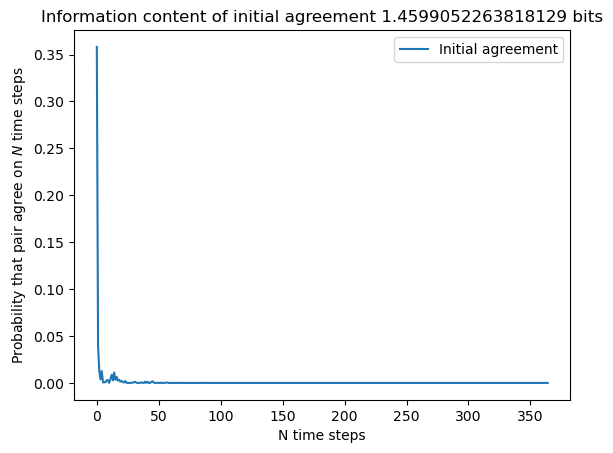

In [39]:
plt.plot(p_space_initial, label='Initial agreement')
plt.title(f"Information content of initial agreement {H_space_initial} bits")
plt.xlabel("N time steps")
plt.ylabel("Probability that pair agree on $N$ time steps")
plt.legend()

In [40]:
memint = dmem.astype(int)

Text(0.5, 1.0, 'All particles Ensemble')

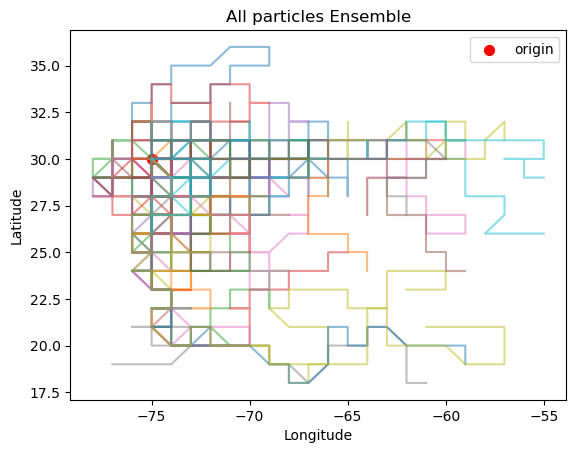

In [41]:
i = range(0, 365)
p = 0
for p in range(0, 50):
    plt.plot(memint.lon[p, i], memint.lat[p, i], alpha=0.5)

plt.scatter(dmem.lon[p, 0], dmem.lat[p, 0], label=f'origin', s=50, marker='o', c='r')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('All particles Ensemble')

In [42]:
time = range(0, 365)
p = 0

mem_Agreement = np.zeros((50, 50))

for i in range(0, 50):
    for j in range(0, 50):
    
        if i == j:
            mem_Agreement[i, j] = np.nan
            initial_agreement[i, j] = np.nan
        else:
            matching_traj = (memint.lon[i, time] == memint.lon[j, time]) & (memint.lat[i, time] == memint.lat[j, time])
            # get index of first false or disagreement
            idx = np.where(matching_traj == False)[0][0]
            # count the number of agreements, which is the index of the first disagreement
            initial_agreement[i, j] = idx
            mem_Agreement[i, j] = np.sum(matching_traj)

Text(0.5, 1.0, 'Agreement between particle paths')

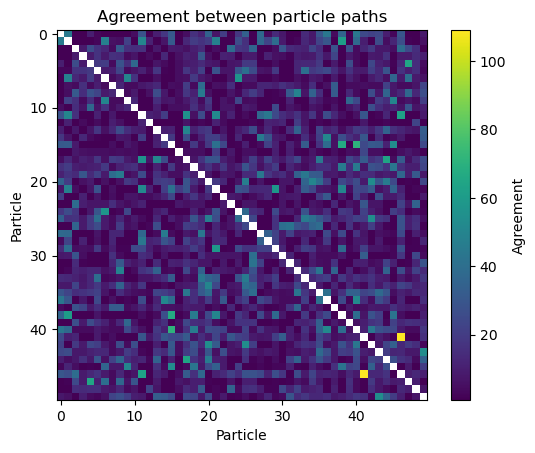

In [43]:
plt.imshow(mem_Agreement)
plt.colorbar(label='Agreement')
plt.xlabel('Particle')
plt.ylabel('Particle')
plt.title('Agreement between particle paths')

In [44]:
max_memagreement = np.where(mem_Agreement == np.nanmax(mem_Agreement))

Text(0.5, 1.0, 'Particle pair with highest agreement =(array([41, 46]), array([46, 41]))')

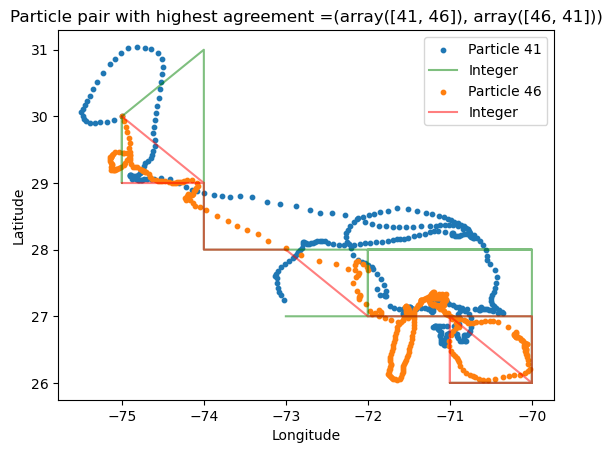

In [46]:
i = range(0, 365)
p = max_memagreement[0][0]
# plt.scatter(dsingle.lon[p, i], dsingle.lat[p, i], label=f'Single precision', s=10)

plt.scatter(dmem.lon[p, i], dmem.lat[p, i], label=f"Particle {p}", s=10)
plt.plot(memint.lon[p, i], memint.lat[p, i], label="Integer", c="g", alpha=0.5)
p = max_memagreement[0][1]
plt.scatter(dmem.lon[p, i], dmem.lat[p, i], label=f"Particle {p}", s=10)
plt.plot(memint.lon[p, i], memint.lat[p, i], label="Integer", c="r", alpha=0.5)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Particle pair with highest agreement ={max_memagreement}")

/tmp/ipykernel_516279/1246942879.py:7: RuntimeWarning: divide by zero encountered in divide
  H_mem = p_mem * np.log2(1/p_mem)


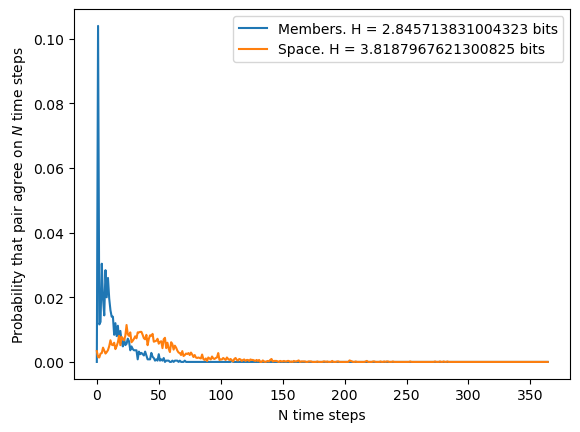

In [95]:
p_mem = np.zeros(365)

for d in range(0, 365):
    A = np.where(mem_Agreement == d)
    p_mem[d] = len(A[0]) / 50**2 / 2

H_mem = p_mem * np.log2(1 / p_mem)
H_mem = H_mem[~np.isnan(H_mem)]
H_mem = np.sum(H_mem)

plt.plot(p_mem, label=f"Members. H = {H_mem} bits")
plt.plot(p_space, label=f"Space. H = {H_space} bits")
plt.xlabel("N time steps")
plt.ylabel("Probability that pair agree on $N$ time steps")
plt.legend()

In [92]:
 H_mem

2.845713831004323